In [212]:
from bs4 import BeautifulSoup
import requests
import nltk
import os
from nltk import sent_tokenize, word_tokenize
import re
import urllib
from collections import Counter
import pandas as pd
import numpy as np



In [213]:
nltk.download('stopwords')
nltk.download('punkt')

stop_words = set(nltk.corpus.stopwords.words())


[nltk_data] Downloading package stopwords to
[nltk_data]     /home/husain3012/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /home/husain3012/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


### Data Acquisition and Preprocessing

In [214]:
def fetch_webpage(url):
    response = requests.get(url)
    return response.text


def clean_text(text):
    text_cleanup_regex = r'[^A-Za-z0-9 ]+'

    cleaned_text = re.sub(text_cleanup_regex,' ', text)

    # remove multiple spaces
    cleaned_text = re.sub(' +', ' ', cleaned_text)

    cleaned_text.strip()
    cleaned_text = cleaned_text.lower()


    # remove stop words
    words = word_tokenize(cleaned_text)
    cleaned_text = ' '.join([word for word in words if word not in stop_words])
    return cleaned_text

def parse_webpage(text):
    soup = BeautifulSoup(text, 'html.parser')
    text = soup.get_text()
    cleaned_text = clean_text(text)
    return cleaned_text



def fetch_wikipedia_pages(category, n, save_to=None):
    processed = 0
    S = requests.Session()

    URL = "https://en.wikipedia.org/w/api.php"

    PARAMS = {
        "action": "query",
        "cmtitle": "Category:" + category,
        "cmlimit": n,
        "list": "categorymembers",
        "format": "json"
    }

    R = S.get(url=URL, params=PARAMS)
    DATA = R.json()
    PAGES = DATA['query']['categorymembers']

    page_ids = [page['pageid'] for page in PAGES]

    pages = []
    #get the content of each page by pageid and save it to a file
    for page_id in page_ids:
        PARAMS = {
            "action": "parse",
            "pageid": page_id,
            "format": "json"
        }
        R = S.get(url=URL, params=PARAMS)
        #use beautifulsoap to parse the content
        DATA = R.json()
        content = DATA['parse']['text']['*']
        text = parse_webpage(content)
       

        if  len(text)<3:
            continue
        
        #save the content in a list
        pages.append({
            'page_id': page_id,
            'page': text
        })
        processed += 1
        

        if save_to!=None:
            filename = str(page_id) + ".txt"
            filename = os.path.join(save_to, filename)
            # make sure the directory exists
            if not os.path.exists(os.path.dirname(filename)):
                os.makedirs(os.path.dirname(filename))

            with open(filename, "w", encoding="utf-8") as file:
                file.write(text)
        print(f"Processed {processed}/{n} pages", end="\r")
    return pages


def load_wikipedia_pages(category, directory):
    pages = []
    for filename in os.listdir(directory):
        with open(os.path.join(directory, filename), "r", encoding="utf-8") as file:
            text = file.read()
            text = clean_text(text)
    
            pages.append({
                'page_id': filename.split(".")[0],
                'page': text
            })
    return pages



In [215]:
# sport_pages = fetch_wikipedia_pages('sports', 50, 'data/sports')
# education_pages = fetch_wikipedia_pages('education', 50, 'data/education')

sport_pages = load_wikipedia_pages('sports', 'data/sports')
education_pages = load_wikipedia_pages('education', 'data/education')

print(f"Loaded {len(sport_pages)} sports pages")
print(f"Loaded {len(education_pages)} education pages")



Loaded 36 sports pages
Loaded 62 education pages


In [216]:
df = pd.DataFrame({
    'PAGE': [page['page'] for page in sport_pages] + [page['page'] for page in education_pages],
    'LENGTH': 0,
    'CATEGORY': ['sports']*len(sport_pages) + ['education']*len(education_pages),
}).sample(frac=1).reset_index(drop=True).dropna()
df['LENGTH'] = df['PAGE'].apply(len)

df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 98 entries, 0 to 97
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   PAGE      98 non-null     object
 1   LENGTH    98 non-null     int64 
 2   CATEGORY  98 non-null     object
dtypes: int64(1), object(2)
memory usage: 2.4+ KB


,PAGE,LENGTH,CATEGORY
0,wikimedia commons media related education syst...,76,education
1,article category regulation sport rules regula...,362,sports
2,biology portal,14,sports
3,container category due scope contain subcatego...,153,education
4,games portal pages category moved subcategorie...,554,sports


### Data analysis

In [238]:
# find the most common words in the sports and education pages, shortest and longest pages, and the average length of the pages
sports_pages = df[df['CATEGORY'] == 'sports']
education_pages = df[df['CATEGORY'] == 'education']

sports_words = word_tokenize(' '.join(sports_pages['PAGE']))
education_words = word_tokenize(' '.join(education_pages['PAGE']))

sports_word_counts = Counter(sports_words)
education_word_counts = Counter(education_words)

print("Most common sports words:")
print(', '.join([f"{word}: {count}" for word, count in sports_word_counts.most_common(10)]))
print("\nMost common education words:")
print(', '.join([f"{word}: {count}"  for word, count in education_word_counts.most_common(10)]))

print("\nAverage sports page length:", sports_pages['LENGTH'].mean())


print("\nAverage education page length:", education_pages['LENGTH'].mean())



print("\nTotal sport words:", len(sports_words))
print("\nTotal education words:", len(education_words))




Most common sports words:
sports: 279, sport: 147, football: 75, team: 73, 2015: 64, archived: 62, original: 59, retrieved: 57, cup: 52, games: 49

Most common education words:
education: 1415, 2023: 416, 10: 407, retrieved: 359, 1: 355, pp: 336, archived: 303, original: 302, 978: 288, isbn: 285

Average sports page length: 2010.5555555555557

Average education page length: 5788.032258064516

Total sport words: 9899

Total education words: 48179


### Unigram and Bigram Matrix

In [218]:
def get_unigram_matrix(df, to_csv=False,):
   
    unigram_counts = Counter()
    for page in df['PAGE']:
        unigram_counts.update(word_tokenize(page))
        
    unigram_matrix = np.zeros((len(df), len(unigram_counts)))
    for i, page in enumerate(df['PAGE']):
        page_counts = Counter(word_tokenize(page))
        for j, word in enumerate(unigram_counts):
            unigram_matrix[i,j] = page_counts[word]

    unigram_matrix_df = pd.DataFrame(unigram_matrix, columns=unigram_counts.keys(), index=df.index)
    unigram_matrix_df['CATEGORY'] = df['CATEGORY']
    return unigram_matrix_df

def get_bigram_matrix(df, to_csv=False):
    bigram_counts = Counter()
    for page in df['PAGE']:
        bigram_counts.update(nltk.bigrams(word_tokenize(page)))
        
    bigram_matrix = np.zeros((len(df), len(bigram_counts)))
    for i, page in enumerate(df['PAGE']):
        page_counts = Counter(nltk.bigrams(word_tokenize(page)))
        for j, bigram in enumerate(bigram_counts):
            bigram_matrix[i,j] = page_counts[bigram]

    bigram_matrix_df = pd.DataFrame(bigram_matrix, columns=bigram_counts.keys(), index=df.index)
    bigram_matrix_df['CATEGORY'] = df['CATEGORY']
    return bigram_matrix_df

In [219]:
unigram_matrix = get_unigram_matrix(df, 'unigram_matrix')
unigram_matrix
    

,wikimedia,commons,media,related,education,systems,category,article,regulation,sport,...,9781932907964,472,oppression,rsd11,mc24,phaidon,375,83866,050,CATEGORY
0,1.0,1.0,1.0,1.0,2.0,2.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,education
1,1.0,1.0,1.0,1.0,0.0,0.0,2.0,1.0,1.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,sports
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,sports
3,1.0,1.0,1.0,1.0,2.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,education
4,1.0,1.0,1.0,2.0,0.0,0.0,4.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,sports
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
93,0.0,0.0,0.0,0.0,6.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,education
94,0.0,0.0,0.0,0.0,13.0,1.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,education
95,1.0,1.0,1.0,1.0,2.0,0.0,1.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,education
96,0.0,0.0,0.0,2.0,60.0,3.0,0.0,3.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,education


In [220]:
bigram_matrix = get_bigram_matrix(df, 'bigram_matrix.csv')
bigram_matrix

,wikimedia,commons,media,related,education,systems,category,systems,article,category,...,phaidon,p,375,1,83866,050,5,p,55,CATEGORY
,commons,media,related,education,systems,category,systems,education,category,regulation,...,press,375,isbn,83866,050,5,laleman,55,isbn,
0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,education
1,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,sports
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,sports
3,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,education
4,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,sports
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
93,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,education
94,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,education
95,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,education


### Bigram probability matrix

### TF IDF Matrix

In [221]:
def get_tf_idf_matrix(df, to_csv=False):
    tf_imatrix = np.zeros((len(df), len(unigram_matrix.columns)-1))
    for i in range(len(df)):
        counts = Counter(word_tokenize(df['PAGE'][i]))
        max_count = max(counts.values())
        for j, word in enumerate(unigram_matrix.columns[:-1]):
            tf_imatrix[i,j] = counts[word] / max_count
    idf_matrix = np.log(len(df) / (unigram_matrix.iloc[:,:-1] > 0).sum())
    tf_idf_matrix = tf_imatrix * idf_matrix.values
    tf_idf_matrix_df = pd.DataFrame(tf_idf_matrix, columns=unigram_matrix.columns[:-1], index=df.index)
    tf_idf_matrix_df['CATEGORY'] = df['CATEGORY']
    return tf_idf_matrix_df

In [222]:
tf_idf_matrix = get_tf_idf_matrix(df, 'tf_idf_matrix.csv')
tf_idf_matrix

,wikimedia,commons,media,related,education,systems,category,article,regulation,sport,...,9781932907964,472,oppression,rsd11,mc24,phaidon,375,83866,050,CATEGORY
0,0.307338,0.297992,0.270958,0.205290,0.693147,2.282382,0.237047,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,education
1,0.204892,0.198661,0.180639,0.136860,0.000000,0.000000,0.316062,0.224315,0.991843,1.167836,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,sports
2,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,sports
3,0.307338,0.297992,0.270958,0.205290,0.693147,0.000000,0.237047,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,education
4,0.122935,0.119197,0.108383,0.164232,0.000000,0.000000,0.379275,0.134589,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,sports
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
93,0.000000,0.000000,0.000000,0.000000,0.259930,0.000000,0.000000,0.042059,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,education
94,0.000000,0.000000,0.000000,0.000000,0.163835,0.041498,0.000000,0.012235,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,education
95,0.307338,0.297992,0.270958,0.205290,0.693147,0.000000,0.237047,0.336472,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,education
96,0.000000,0.000000,0.000000,0.012076,0.611600,0.100693,0.000000,0.029689,0.043758,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,education


## Naive Bayes Classification

In [223]:
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
import seaborn as sns

## Classification
|Label|Description|
|---|---|
|0|Sports|
|1|Education|

In [259]:
labels = [0, 1]
MODEL_TO_USE = GaussianNB
TEST_SIZE = 0.25

### Classification on Unigram Matrix

In [260]:
x_train_ug, x_test_ug, y_train_ug, y_test_ug = train_test_split(unigram_matrix.iloc[:,:-1], unigram_matrix['CATEGORY'], test_size=TEST_SIZE, random_state=42)



In [261]:
nb_ug = MODEL_TO_USE()
nb_ug.fit(x_train_ug, y_train_ug)

/home/husain3012/anaconda3/envs/deeplearning/lib/python3.11/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/home/husain3012/anaconda3/envs/deeplearning/lib/python3.11/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/home/husain3012/anaconda3/envs/deeplearning/lib/python3.11/site-packages/sklearn/utils/validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/home/husain3012/anaconda3/envs/deeplearning/lib/python3.11/site-packages/sklearn/utils/validation.py:605: FutureWarn

GaussianNB()

/home/husain3012/anaconda3/envs/deeplearning/lib/python3.11/site-packages/sklearn/utils/validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():


/home/husain3012/anaconda3/envs/deeplearning/lib/python3.11/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/home/husain3012/anaconda3/envs/deeplearning/lib/python3.11/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/home/husain3012/anaconda3/envs/deeplearning/lib/python3.11/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/home/husain3012/anaconda3/envs/deeplearning/lib/python3.11/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed 

0.56


/home/husain3012/anaconda3/envs/deeplearning/lib/python3.11/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/home/husain3012/anaconda3/envs/deeplearning/lib/python3.11/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/home/husain3012/anaconda3/envs/deeplearning/lib/python3.11/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/home/husain3012/anaconda3/envs/deeplearning/lib/python3.11/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed 

0.863013698630137


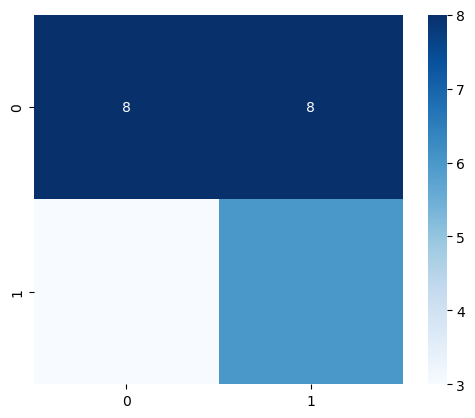

In [277]:
y_pred_unigram = nb_ug.predict(x_test_ug)
matrix_confusion = confusion_matrix(y_test_ug, y_pred_unigram)
sns.heatmap(matrix_confusion, square=True, annot=True, cmap='Blues', fmt='d')
acc_ug = accuracy_score(y_test_ug, y_pred_unigram)
print(acc_ug)

y_pred_train = nb_ug.predict(x_train_ug)
acc_train_ug = accuracy_score(y_train_ug, y_pred_train)
print(acc_train_ug)

## Classification on Bigram Matrix

In [263]:
X_train_bigram, X_test_bigram, y_train_bigram, y_test_bigram = train_test_split(bigram_matrix.iloc[:,:-1], bigram_matrix['CATEGORY'], test_size=TEST_SIZE, random_state=42)

In [264]:
nb_bg = MODEL_TO_USE()
nb_bg.fit(X_train_bigram, y_train_bigram)

/home/husain3012/anaconda3/envs/deeplearning/lib/python3.11/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/home/husain3012/anaconda3/envs/deeplearning/lib/python3.11/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/home/husain3012/anaconda3/envs/deeplearning/lib/python3.11/site-packages/sklearn/utils/validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():


/home/husain3012/anaconda3/envs/deeplearning/lib/python3.11/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/home/husain3012/anaconda3/envs/deeplearning/lib/python3.11/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):


GaussianNB()

/home/husain3012/anaconda3/envs/deeplearning/lib/python3.11/site-packages/sklearn/utils/validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():


/home/husain3012/anaconda3/envs/deeplearning/lib/python3.11/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/home/husain3012/anaconda3/envs/deeplearning/lib/python3.11/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/home/husain3012/anaconda3/envs/deeplearning/lib/python3.11/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/home/husain3012/anaconda3/envs/deeplearning/lib/python3.11/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed 

0.68


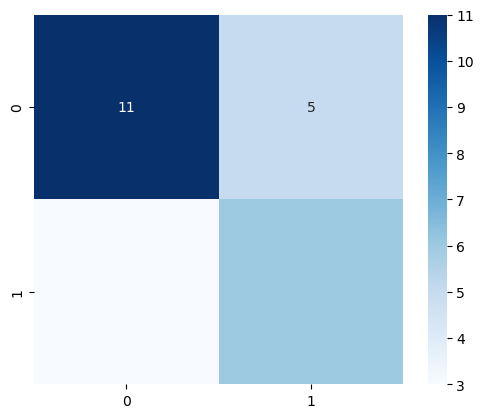

In [265]:
y_pred_bigram = nb_bg.predict(X_test_bigram)
matrix_confusion = confusion_matrix(y_test_bigram, y_pred_bigram)
sns.heatmap(matrix_confusion, square=True, annot=True, cmap='Blues', fmt='d')
acc_bg = accuracy_score(y_test_bigram, y_pred_bigram)
print(acc_bg)

## Classification on TF IDF Matrix

In [266]:
x_train_tfidf, x_test_tfidf, y_train_tfidf, y_test_tfidf = train_test_split(tf_idf_matrix.iloc[:,:-1], tf_idf_matrix['CATEGORY'], test_size=TEST_SIZE, random_state=42)

In [267]:
nb_tfidf = MODEL_TO_USE()
nb_tfidf.fit(x_train_tfidf, y_train_tfidf)

/home/husain3012/anaconda3/envs/deeplearning/lib/python3.11/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/home/husain3012/anaconda3/envs/deeplearning/lib/python3.11/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/home/husain3012/anaconda3/envs/deeplearning/lib/python3.11/site-packages/sklearn/utils/validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():


/home/husain3012/anaconda3/envs/deeplearning/lib/python3.11/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/home/husain3012/anaconda3/envs/deeplearning/lib/python3.11/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):


GaussianNB()

/home/husain3012/anaconda3/envs/deeplearning/lib/python3.11/site-packages/sklearn/utils/validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/home/husain3012/anaconda3/envs/deeplearning/lib/python3.11/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/home/husain3012/anaconda3/envs/deeplearning/lib/python3.11/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):


/home/husain3012/anaconda3/envs/deeplearning/lib/python3.11/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/home/husain3012/anaconda3/envs/deeplearning/lib/python3.11/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/home/husain3012/anaconda3/envs/deeplearning/lib/python3.11/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/home/husain3012/anaconda3/envs/deeplearning/lib/python3.11/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed 

0.68


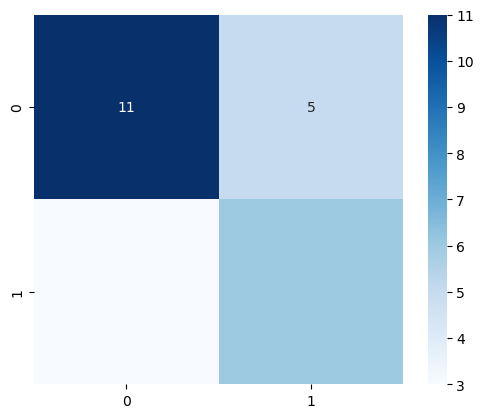

In [268]:
y_pred_tfidf = nb_tfidf.predict(x_test_tfidf)
matrix_confusion = confusion_matrix(y_test_tfidf, y_pred_tfidf)
sns.heatmap(matrix_confusion, square=True, annot=True, cmap='Blues', fmt='d')
acc_tfidf = accuracy_score(y_test_tfidf, y_pred_tfidf)
print(acc_tfidf)



## Comparison of the three models

Model Used: GaussianNB
Bigram: 0.68
TF-IDF: 0.68
Unigram: 0.56


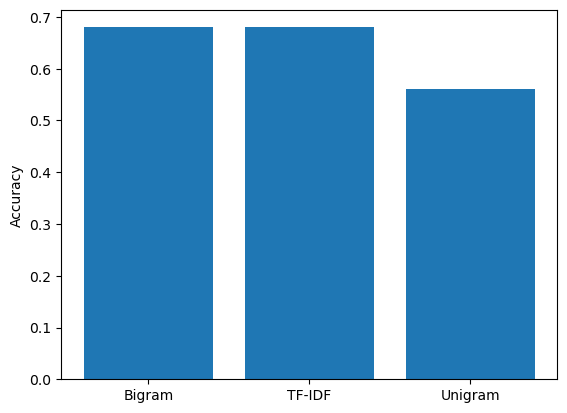

In [269]:
print(f"Model Used: {MODEL_TO_USE.__name__}", )

accuracies = [{'model': 'Unigram', 'accuracy': acc_ug}, {'model': 'Bigram', 'accuracy': acc_bg}, {'model': 'TF-IDF', 'accuracy': acc_tfidf}]
accuracies.sort(key=lambda x: x['accuracy'], reverse=True)
for acc in accuracies:
    print(f"{acc['model']}: {acc['accuracy']}")
plt.bar([acc['model'] for acc in accuracies], [acc['accuracy'] for acc in accuracies])
plt.ylabel('Accuracy')
plt.show()


### Unseen data 

In [270]:
test_file = 'data/test2.txt'

In [271]:
text = ''
with open(test_file, 'r', encoding='utf-8') as file:
    text = file.read()
    print(text)



Title: The Sporting Saga of Hockey and Cricket: A Tale of Passion, Tradition, and National Pride

In the diverse tapestry of sports that captivate the hearts of millions around the globe, hockey and cricket stand as two towering pillars, each with its own rich history, fervent fanbase, and enduring legacy. From the green fields of cricket to the icy arenas of hockey, these sports symbolize the spirit of competition, camaraderie, and national pride. In this article, we delve into the captivating world of hockey and cricket, exploring their significance, evolution, and enduring impact on the cultural fabric of nations.

**Cricket: The Gentleman's Game**

Cricket, often hailed as the gentleman's game, holds a special place in the hearts of millions, particularly in countries like India, England, Australia, and the West Indies. Rooted in tradition and steeped in history, cricket is more than just a sport; it is a cultural phenomenon that unites people across borders, languages, and generat

In [272]:
cleaned_text = clean_text(text)
print(cleaned_text)

title sporting saga hockey cricket passion tradition national pride diverse tapestry sports captivate hearts millions globe hockey cricket stand towering pillars rich history fervent fanbase enduring legacy green fields cricket icy arenas hockey sports symbolize spirit competition camaraderie national pride article delve captivating world hockey cricket exploring significance evolution enduring impact cultural fabric nations cricket gentleman game cricket hailed gentleman game holds special place hearts millions particularly countries india england australia west indies rooted tradition steeped history cricket sport cultural phenomenon unites borders languages generations storied rivalries ashes series electrifying atmosphere indian premier league ipl cricket offers spectacle blending skill strategy sheer athleticism iconic sound leather willow roar crowd nail biting finishes cemented cricket status global spectacle attracting legions fans shaping identities nations hockey fast furious

In [273]:


unigram_matrix_unseen = np.zeros((1, len(unigram_matrix.columns)-1))
for j, word in enumerate(unigram_matrix.columns[:-1]):
    unigram_matrix_unseen[0,j] = cleaned_text.count(word)

# predict the category of the unseen text
print(nb_ug.predict(unigram_matrix_unseen))


['education']


/home/husain3012/anaconda3/envs/deeplearning/lib/python3.11/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but GaussianNB was fitted with feature names
  warnings.warn(
